# Clustering Assignement - Countries Data analysis
#### by Saranga Hebbar

#### Overview of Dataset:
    Countries data file is having the data of 167 countries data on its GDP and health realted parameters. 
    
#### Problem Statement:
    HELP International is a NGO that is committed to fight against poverty and it has recently got $10,000,000.00 funding from different sources. The NGO's CEO intends to spend this money for the contries in real need strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 

#### Solution Expected:
    As a Data analyst, will have to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then will have to suggest the countries which the CEO needs to focus on the most.

#### Solution:
    The steps are broadly:

    1. Read and understand the data
    2. Clean the data
    3. Prepare the data for modelling
    4. Modelling 
        a) K-Means Modelling
        b) Hierarchical modelling
    5. Cluster Profiling
    6. Final analysis and recommendation
    

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### 1. Read and Understand the data

In [47]:
# read the dataset
country_df = pd.read_csv("Country-data.csv", sep=",", encoding="ISO-8859-1", header=0)
country_df.head(200)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [3]:
# basics of the df
country_df.info()
country_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


(167, 10)

### 2. Data Cleaning

In [4]:
# missing values
round(100*(country_df.isnull().sum())/len(country_df), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

    No Missing values in the dataset. Proceeding further with next analysis

##### Converting the columns: exports, imports and health
###### These 3 columns are in the percentage of GDPP. Hence converting them to the right amount

In [5]:
country_df['export_amt'] = country_df.gdpp * country_df.exports / 100
country_df['import_amt'] = country_df.gdpp * country_df.imports / 100
country_df['health_expenses'] = country_df.gdpp * country_df.health / 100

In [6]:
## removing the original columns that are in percentage values
del country_df['exports']
del country_df['imports']
del country_df['health']
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,export_amt,import_amt,health_expenses
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,248.297,41.9174
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,1987.740,267.8950
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,1400.440,185.9820
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,1514.370,100.6050
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,7185.800,735.6600


In [7]:
country_df.describe()

,child_mort,income,inflation,life_expec,total_fer,gdpp,export_amt,import_amt,health_expenses
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,17144.688623,7.781832,70.555689,2.947964,12964.155689,7420.618847,6588.352108,1056.733204
std,40.328931,19278.067698,10.570704,8.893172,1.513848,18328.704809,17973.885795,14710.810418,1801.408906
min,2.600000,609.000000,-4.210000,32.100000,1.150000,231.000000,1.076920,0.651092,12.821200
25%,8.250000,3355.000000,1.810000,65.300000,1.795000,1330.000000,447.140000,640.215000,78.535500
50%,19.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,1777.440000,2045.580000,321.886000
75%,62.100000,22800.000000,10.750000,76.800000,3.880000,14050.000000,7278.000000,7719.600000,976.940000
max,208.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000,183750.000000,149100.000000,8663.600000


In [8]:
### Converting the columns from numeric to categorized columns for the attribute analysis
country_df['child_mort_cat'] = pd.cut(country_df.child_mort,[0,10,50,100,150,250],labels=['0-10','11-50','51-100','101-150','151-250'])
country_df['income_cat'] = pd.cut(country_df.income,[0,3000,10000,50000,125000],labels=['< 3k','3k-10k','10k-50k','> 50k'])
country_df['life_expec_cat'] = pd.cut(country_df.life_expec,[30,40,50,60,70,85],labels=['30 - 40','40 - 50','50 - 60', '60 - 70', ' 70+' ])
country_df['gdpp_cat'] = pd.cut(country_df.gdpp,[0,500,1500,5000,15000,105000],labels=['<500','500-1.5k','1.5k-5k','5k-15k','>15k'])

In [9]:
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,export_amt,import_amt,health_expenses,child_mort_cat,income_cat,life_expec_cat,gdpp_cat
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,248.297,41.9174,51-100,< 3k,50 - 60,500-1.5k
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,1987.740,267.8950,11-50,3k-10k,70+,1.5k-5k
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,1400.440,185.9820,11-50,10k-50k,70+,1.5k-5k
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,1514.370,100.6050,101-150,3k-10k,60 - 70,1.5k-5k
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,7185.800,735.6600,11-50,10k-50k,70+,5k-15k


#### Univariate Analysis

C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

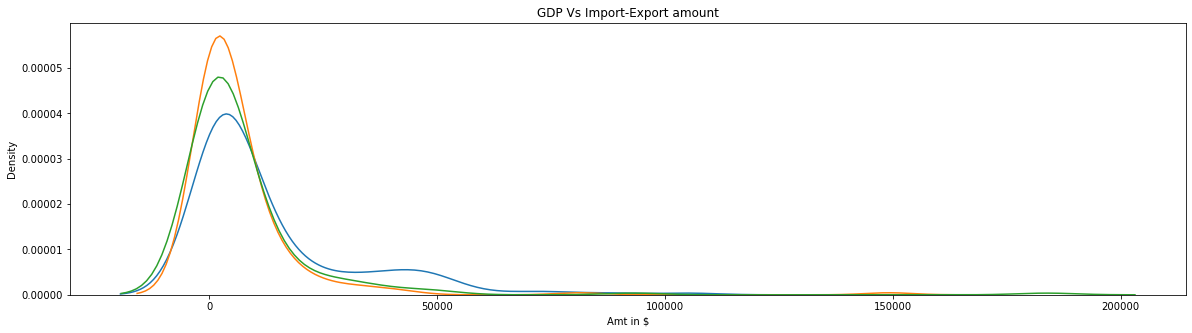

In [10]:
#Child mortality
plt.figure(figsize=[20,5])
ax=sns.distplot(country_df.gdpp,hist=False,label = 'GDP Per Capita')
ax=sns.distplot(country_df.import_amt,hist=False,label = 'Import Amount')
ax=sns.distplot(country_df.export_amt,hist=False,label = 'Export Amount')
ax.set(xlabel='Amt in $',title='GDP Vs Import-Export amount')
plt.show()

C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

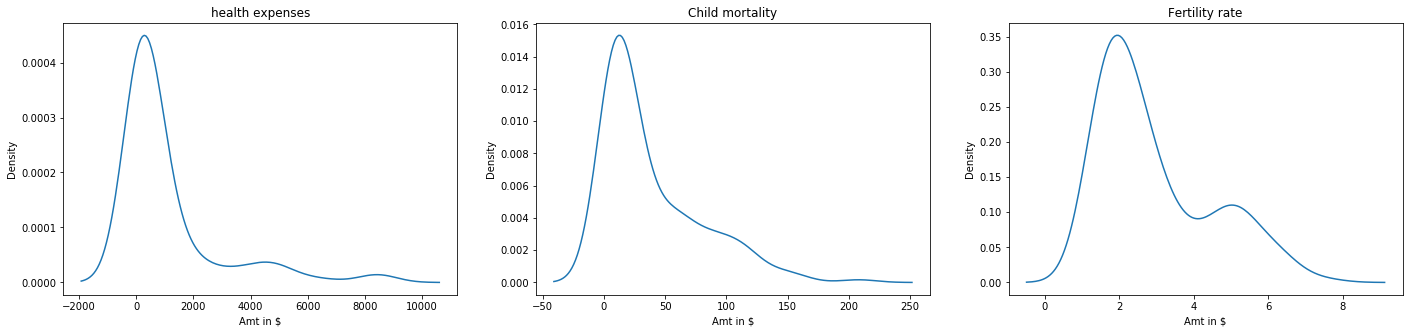

In [11]:
#Child mortality
plt.figure(figsize = (24,5))
plt.subplot(1,3,1)
ax=sns.distplot(country_df.health_expenses,hist=False,label = 'Health Expenses')
ax.set(xlabel='Amt in $',title='health expenses')
plt.subplot(1,3,2)
ax=sns.distplot(country_df.child_mort,hist=False,label = 'Child Mortality')
ax.set(xlabel='Amt in $',title='Child mortality')
plt.subplot(1,3,3)
ax=sns.distplot(country_df.total_fer,hist=False,label = 'Fertility Rate')
ax.set(xlabel='Amt in $',title='Fertility rate')
plt.show()

C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\saranga.hebbar\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\User

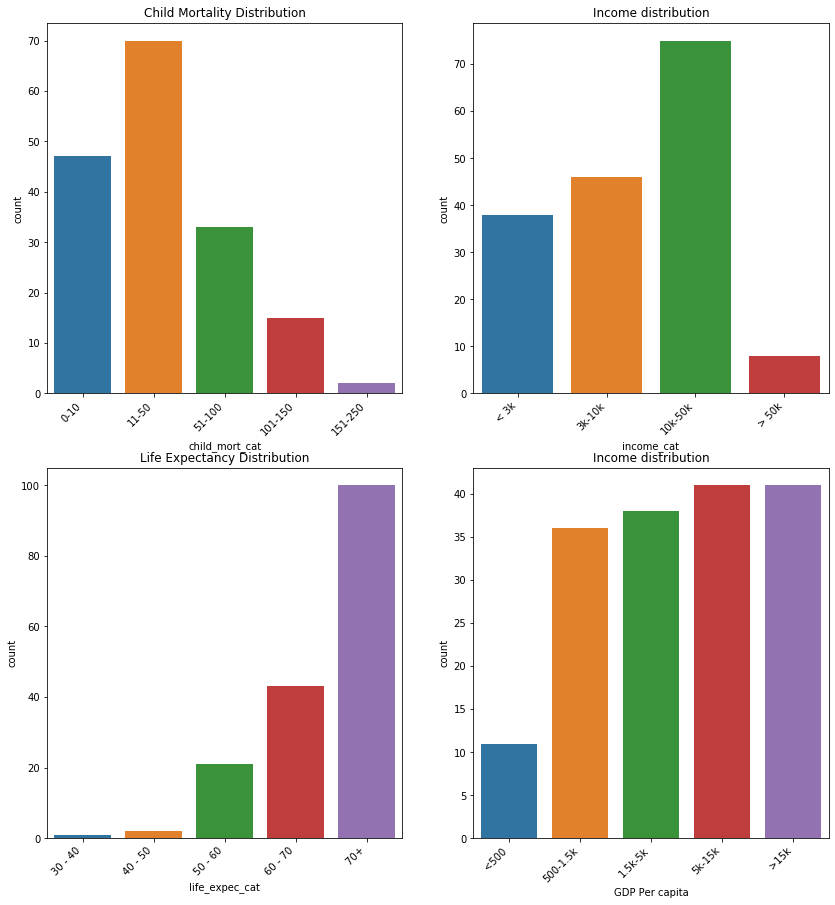

In [12]:
### univariate analysis
plt.figure(figsize = (14,15))
plt.subplot(2,2,1)
plt.title("Child Mortality Distribution")
chart = sns.countplot(country_df['child_mort_cat'], label = 'Child Mortality')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.subplot(2,2,2)
plt.title("Income distribution")
chart = sns.countplot(country_df['income_cat'], label = 'GDP Per Capita')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.subplot(2,2,3)
plt.title("Life Expectancy Distribution")
chart = sns.countplot(country_df['life_expec_cat'], label = 'Life Expectancy')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.subplot(2,2,4)
plt.title("Income distribution")
chart = sns.countplot(country_df['gdpp_cat'], label = 'GDP Per Capita')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel("GDP Per capita")
plt.show()

##### Univariate analysis Inference:
    1. More than 50% of the countries have $5000 and more GDP per capita 
    2. The Child mortality of countries are highest in the range of 11-50 

#### Bivariate analysis

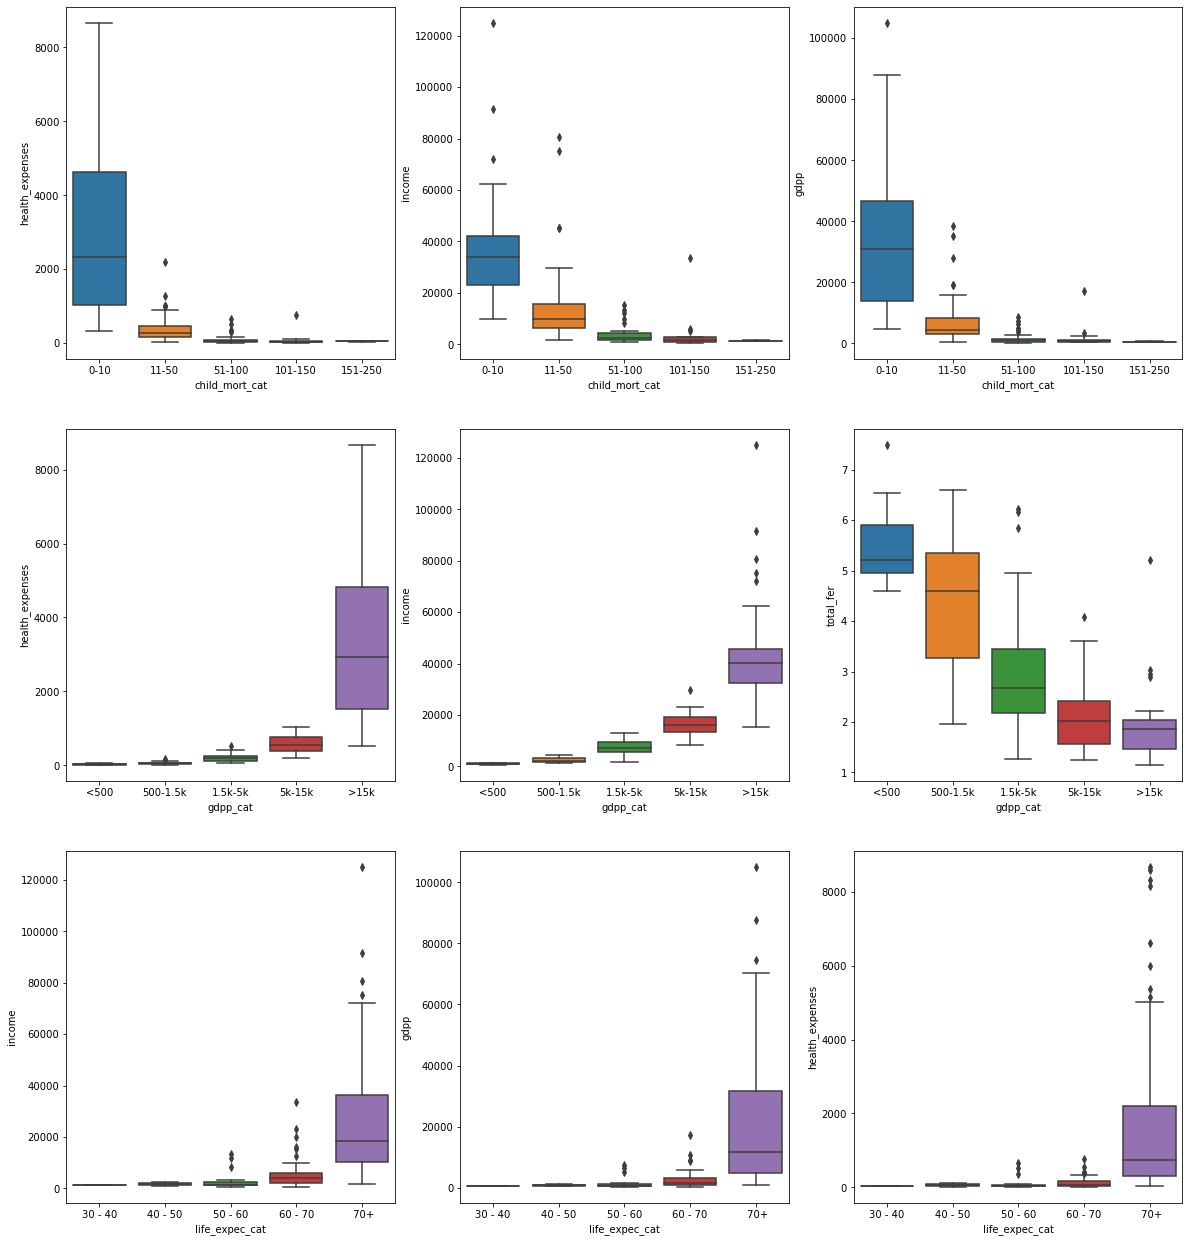

In [13]:
plt.figure(figsize=(20, 22))
plt.subplot(3,3,1)
sns.boxplot(x='child_mort_cat',y='health_expenses',data=country_df)
plt.subplot(3,3,2)
sns.boxplot(x='child_mort_cat',y='income',data=country_df)
plt.subplot(3,3,3)
sns.boxplot(x='child_mort_cat',y='gdpp',data=country_df)
plt.subplot(3,3,4)
sns.boxplot(x='gdpp_cat',y='health_expenses',data=country_df)
plt.subplot(3,3,5)
sns.boxplot(x='gdpp_cat',y='income',data=country_df)
plt.subplot(3,3,6)
sns.boxplot(x='gdpp_cat',y='total_fer',data=country_df)
plt.subplot(3,3,7)
sns.boxplot(x='life_expec_cat',y='income',data=country_df)
plt.subplot(3,3,8)
sns.boxplot(x='life_expec_cat',y='gdpp',data=country_df)
plt.subplot(3,3,9)
sns.boxplot(x='life_expec_cat',y='health_expenses',data=country_df)
plt.show()

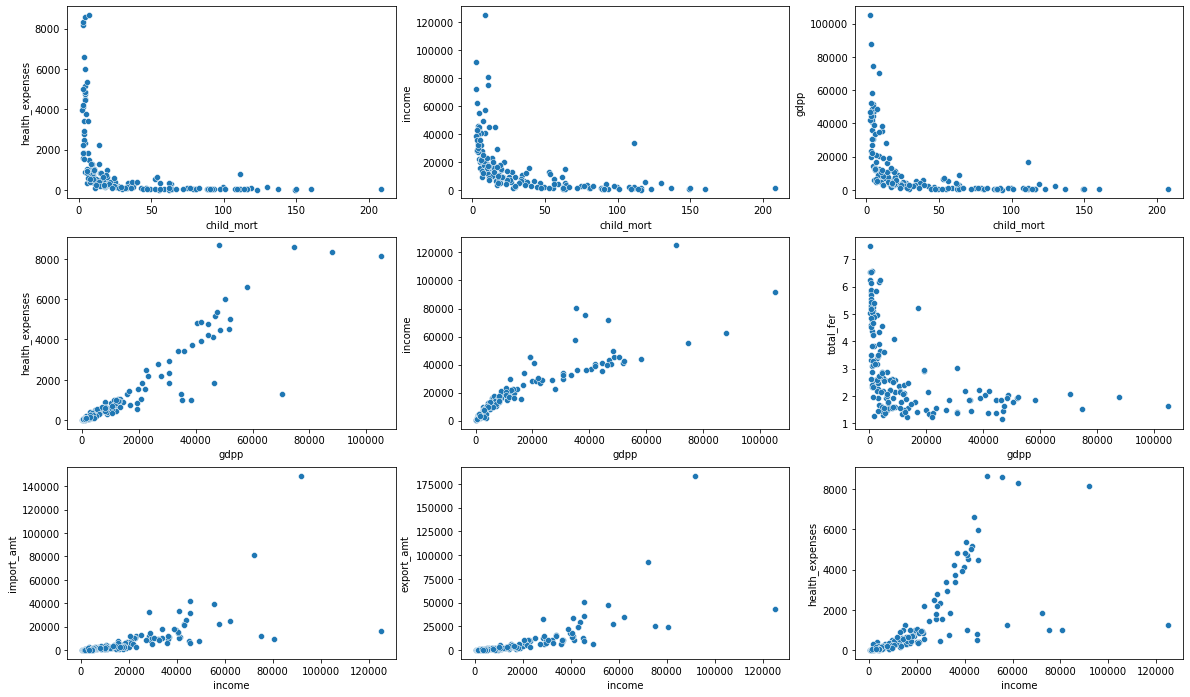

In [14]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.scatterplot(x='child_mort',y='health_expenses',data=country_df)
plt.subplot(3,3,2)
sns.scatterplot(x='child_mort',y='income',data=country_df)
plt.subplot(3,3,3)
sns.scatterplot(x='child_mort',y='gdpp',data=country_df)
plt.subplot(3,3,4)
sns.scatterplot(x='gdpp',y='health_expenses',data=country_df)
plt.subplot(3,3,5)
sns.scatterplot(x='gdpp',y='income',data=country_df)
plt.subplot(3,3,6)
sns.scatterplot(x='gdpp',y='total_fer',data=country_df)
plt.subplot(3,3,7)
sns.scatterplot(x='income',y='import_amt',data=country_df)
plt.subplot(3,3,8)
sns.scatterplot(x='income',y='export_amt',data=country_df)
plt.subplot(3,3,9)
sns.scatterplot(x='income',y='health_expenses',data=country_df)
plt.show()

#### Bivariate analysis Inference
    1. Child mortality is higher when there is lower health related expenditures (Graph 1,1) and similarly when there is higher health expenses, then the life expectancy is also gets higher (Graph 3,3). 
    2. Child mortality gets higher when the income is lower and at the country level when the GDPP is lower.
    3. Wherever there is higher GDPP, the health expenses increases (Graph 2,1 and Graph 2,2) but people tend to have lower number of kids (Graph 2,3)    

### 3. Prepare the data for Modelling

In [15]:
grouped_df = country_df[['child_mort','income','life_expec','gdpp']]

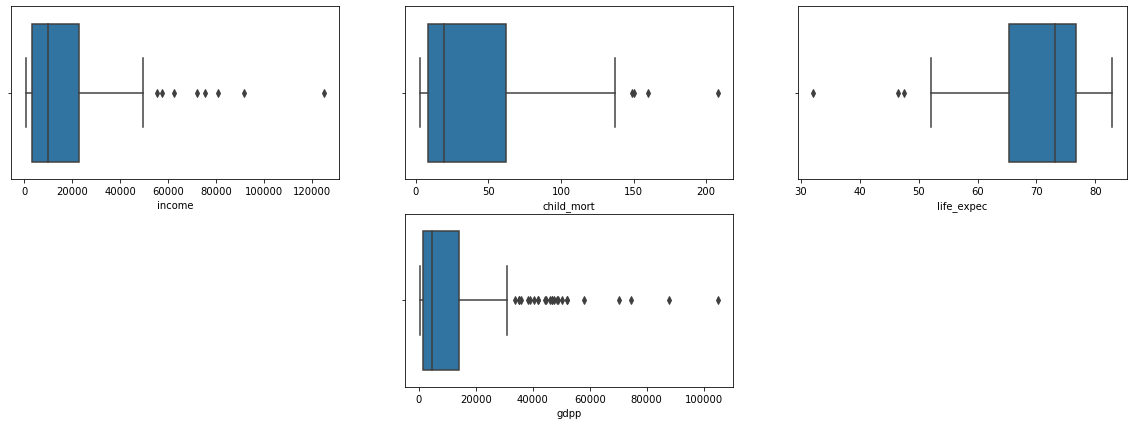

In [16]:
plt.figure(figsize=(20, 7))
plt.subplot(2,3,1)
sns.boxplot(x='income',data = grouped_df)
plt.subplot(2,3,2)
sns.boxplot(x='child_mort',data = grouped_df)
plt.subplot(2,3,3)
sns.boxplot(x='life_expec',data = grouped_df)
plt.subplot(2,3,5)
sns.boxplot(x='gdpp',data = grouped_df)
plt.show()

##### Inferences
    * There is quite a few countries that are having income range lying on the outlier. (Graph 1,1) 
    These countries can be removed as these countries would not need assistance from the NGO.
    * The Child mortality graph has outlier, but these can not be removed as these are the countries that really needs to be looked into for a in-depth need of assistance.
    * The Life expectancy with lower age band is also part of our analysis to validate if they would need financial assistance. Hence not removing
    * The GDPP graph has high number of outliers at the higher band but the number of such countries are much larger in number and since the dataset is is of lower in size (167 rows) and removing close to 10% of rows would not be a good idea. Hence will keep them in the dataset  

In [17]:
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,export_amt,import_amt,health_expenses,child_mort_cat,income_cat,life_expec_cat,gdpp_cat
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,248.297,41.9174,51-100,< 3k,50 - 60,500-1.5k
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,1987.740,267.8950,11-50,3k-10k,70+,1.5k-5k
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,1400.440,185.9820,11-50,10k-50k,70+,1.5k-5k
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,1514.370,100.6050,101-150,3k-10k,60 - 70,1.5k-5k
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,7185.800,735.6600,11-50,10k-50k,70+,5k-15k


In [18]:
#Since in our analysis, we need to identify the countries that have very low GDP & income and high child mortality, we will keep the IQR range to be in between 10% to 80%
#When the IQR is changed from 10% to 80%,
Q1 = grouped_df.gdpp.quantile(0.10)
Q3 = grouped_df.gdpp.quantile(0.80)
IQR = Q3 - Q1

#grouped_df[(country_df.gdpp >= Q1 - 1.5*IQR) & (country_df.gdpp <= Q3 + 1.5*IQR)]
grouped_df[(country_df.income > Q3 + 1.5*IQR)]

,child_mort,income,life_expec,gdpp
23,10.5,80600,77.1,35300
82,10.8,75200,78.2,38500
91,2.8,91700,81.3,105000
114,3.2,62300,81.0,87800
123,9.0,125000,79.5,70300
133,2.8,72100,82.7,46600
145,4.5,55500,82.2,74600
157,8.6,57600,76.5,35000


#### Here the countries with higher GDP with above the IQR of 10-80% is 12 in number, close to 10% of the total dataset. Removing them is not a good idea. Hence Keeping them 

#### Scaling of the data

In [19]:
# instantiate
scaler = StandardScaler()
# fit_transform

#having the scaled dataframe for K-Means clustering
grouped_df_scaled_k = scaler.fit_transform(grouped_df)
#converting it into dataframe
grouped_df_scaled_k = pd.DataFrame(grouped_df_scaled_k)
grouped_df_scaled_k.columns = ['child_mort','income','life_expec','gdpp']

#having the similar copy for hierarchical clustering
grouped_df_scaled_h = scaler.fit_transform(grouped_df)
#converting it into dataframe
grouped_df_scaled_h = pd.DataFrame(grouped_df_scaled_h)
grouped_df_scaled_h.columns = ['child_mort','income','life_expec','gdpp']

#### Hopkins Statistic

In [20]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [21]:
hopkins(grouped_df_scaled_k)

0.9390399359155865

#### Hopkins statistics value 0.9326 shows that it has a high tendency to cluster. 

### 4. Modelling

#### a) K-Means Clustering

##### Steps to be followed
    i)   First create the elbow curve by using the range of clusters from 2 to 8 
    ii)  Then Use the Sillhoutte method to identify the ideal number of clusters
    iii) Based on the 2 methods finalize the number of clusters to be used for the K-Means clustering
    iv)  Use the number of clusters based on the above step and build the K-Means clustering algorithm on the dataset

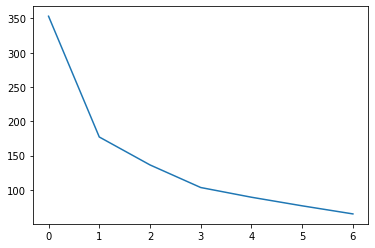

In [22]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(grouped_df_scaled_k)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

##### Here the at the 2nd point (number of cluster = 3) has the right number of clusters 

In [23]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(grouped_df_scaled_k)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(grouped_df_scaled_k, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.502756018954218
For n_clusters=3, the silhouette score is 0.5141001307914609
For n_clusters=4, the silhouette score is 0.5022692578759061
For n_clusters=5, the silhouette score is 0.4504099746745189
For n_clusters=6, the silhouette score is 0.41678386351288577
For n_clusters=7, the silhouette score is 0.4142496680957173
For n_clusters=8, the silhouette score is 0.351564067347641


##### Here at n_clusters=3, the silhouette score is ideal. 

##### Since both Elbow curve and Silhouette analysis gives number of clusters = 3 as an ideal count, we will build the K-Means model with k=3

In [24]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(grouped_df_scaled_k)

KMeans(max_iter=50, n_clusters=3)

In [25]:
kmeans.labels_

array([1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1,
       0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 0,
       1, 0, 2, 1, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       2, 2, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 0,
       1, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1])

In [26]:
## Adding the cluster_id from the kmeans.labels_ to each row. Also adding the country name to each row 
grouped_df_scaled_k['cluster_id'] = kmeans.labels_
grouped_df_scaled_k['Country'] = country_df.country

In [27]:
grouped_df_scaled_k[grouped_df_scaled_k.cluster_id == 0 ].head()

,child_mort,income,life_expec,gdpp,cluster_id,Country
1,-0.538949,-0.375369,0.647866,-0.485623,0,Albania
2,-0.272833,-0.220844,0.670423,-0.465376,0,Algeria
4,-0.695634,0.101732,0.704258,-0.041817,0,Antigua and Barbuda
5,-0.591177,0.080920,0.591474,-0.145791,0,Argentina
6,-0.501643,-0.543421,0.309514,-0.533233,0,Armenia


In [28]:
grouped_df_scaled_k[grouped_df_scaled_k.cluster_id == 1 ].head()

,child_mort,income,life_expec,gdpp,cluster_id,Country
0,1.291532,-0.808245,-1.619092,-0.679180,1,Afghanistan
3,2.007808,-0.585043,-1.179234,-0.516268,1,Angola
17,1.808842,-0.797319,-0.987502,-0.667961,1,Benin
21,0.353908,-0.200033,-1.517586,-0.361949,1,Botswana
25,1.933196,-0.817611,-1.427359,-0.677976,1,Burkina Faso


In [29]:
grouped_df_scaled_k[grouped_df_scaled_k.cluster_id == 2].head()

,child_mort,income,life_expec,gdpp,cluster_id,Country
7,-0.832423,1.261966,1.290735,2.130699,2,Australia
8,-0.844858,1.355617,1.121559,1.857082,2,Austria
11,-0.737914,1.246357,0.614031,0.423331,2,Bahrain
15,-0.839884,1.246357,1.065167,1.720274,2,Belgium
23,-0.690660,3.301480,0.738094,1.222291,2,Brunei


In [30]:
## Adding cluster_id that is assigned by the model to the country_df dataframe
country_df['cluster_id_k'] = kmeans.labels_
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,export_amt,import_amt,health_expenses,child_mort_cat,income_cat,life_expec_cat,gdpp_cat,cluster_id_k
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,248.297,41.9174,51-100,< 3k,50 - 60,500-1.5k,1
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,1987.740,267.8950,11-50,3k-10k,70+,1.5k-5k,0
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,1400.440,185.9820,11-50,10k-50k,70+,1.5k-5k,0
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,1514.370,100.6050,101-150,3k-10k,60 - 70,1.5k-5k,1
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,7185.800,735.6600,11-50,10k-50k,70+,5k-15k,0


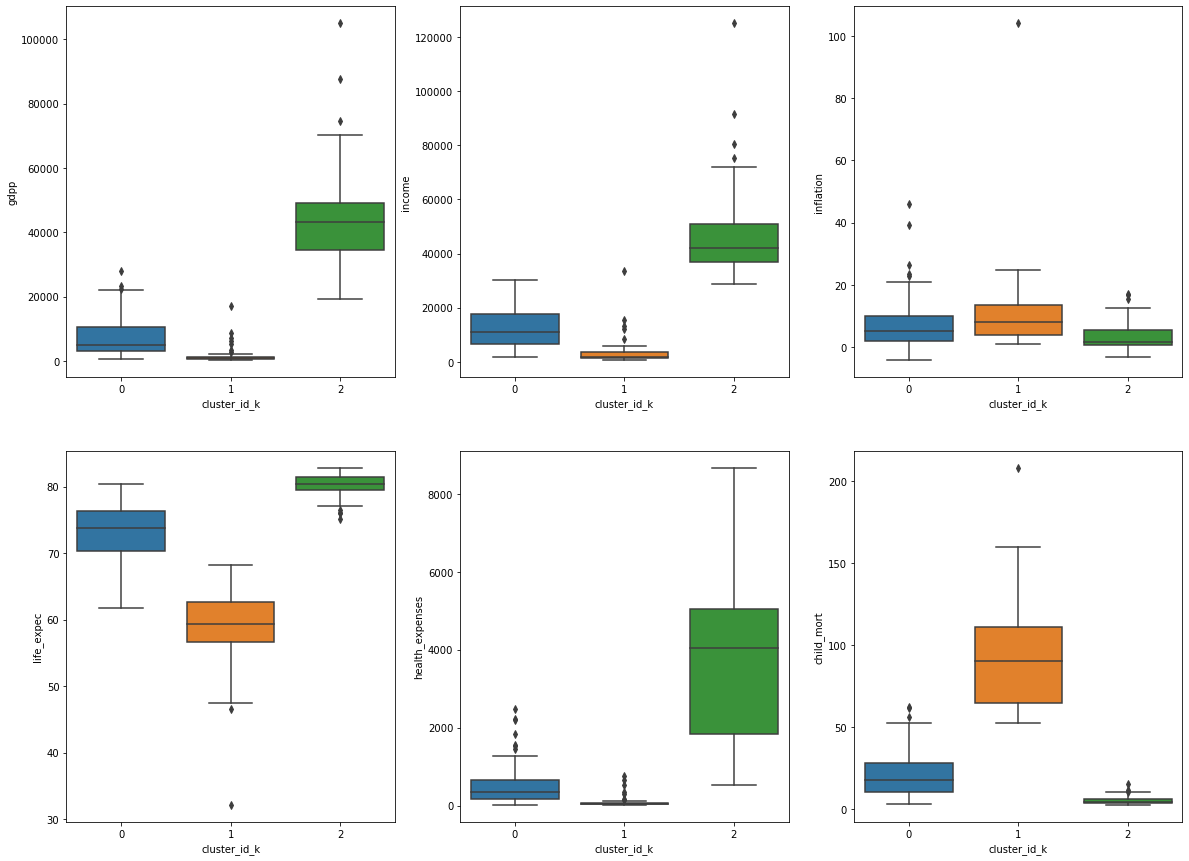

In [31]:
# plot
plt.figure(figsize=(20, 15))
plt.subplot(2,3,1)
sns.boxplot(x='cluster_id_k', y='gdpp', data=country_df)
plt.subplot(2,3,2)
sns.boxplot(x='cluster_id_k', y='income', data=country_df)
plt.subplot(2,3,3)
sns.boxplot(x='cluster_id_k', y='inflation', data=country_df)
plt.subplot(2,3,4)
sns.boxplot(x='cluster_id_k', y='life_expec', data=country_df)
plt.subplot(2,3,5)
sns.boxplot(x='cluster_id_k', y='health_expenses', data=country_df)
plt.subplot(2,3,6)
sns.boxplot(x='cluster_id_k', y='child_mort', data=country_df)
plt.show()

#### Inference on Clusters that are built by the model
    * Cluster_id = 0 : 
            Very Low 
                GDPP
                Income
                Life Expectancy
                health expenses
            Very high
                Child Mortality rate

    * Cluster_id = 2 : 
           Medium 
                GDPP
                Income
                Life Expectancy
                health expenses
                Child Mortality rate

    * Cluster_id = 1 : 
            Very High 
                GDPP
                Income
                Life Expectancy
                health expenses
            Very low
                Child Mortality rate


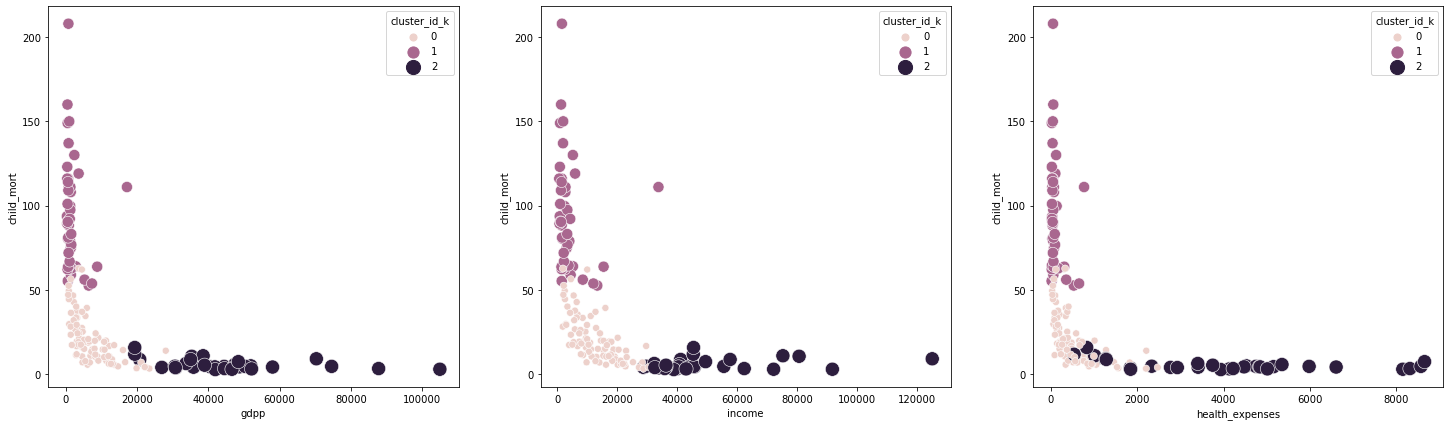

In [32]:
# plot
plt.figure(figsize=(25, 7))
plt.subplot(1,3,1)
sns.scatterplot(x='gdpp',y='child_mort',hue='cluster_id_k', data=country_df,size='cluster_id_k',sizes=(50,200))
plt.subplot(1,3,2)
sns.scatterplot(x='income',y='child_mort',hue='cluster_id_k', data=country_df,size='cluster_id_k',sizes=(50,200))
plt.subplot(1,3,3)
sns.scatterplot(x='health_expenses',y='child_mort',hue='cluster_id_k', data=country_df,size='cluster_id_k',sizes=(50,200))
plt.show()

##### Based on the above cluster characteristics, it is clear that, the countries coming under cluster_id = 0 will be the ideal candidates for the NGO to provide the financial assistance 

#### b) Hierarchical clustering

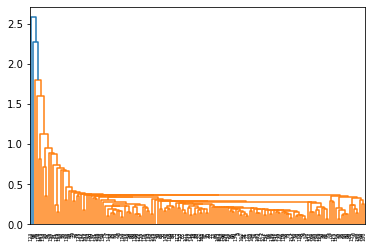

In [33]:
# single linkage
mergings = linkage(grouped_df_scaled_h, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

In [34]:
# 3 clusters for having the right comparison with K-Means clustering output
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
# assign cluster labels
country_df['cluster_id_h_single'] = cluster_labels
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,export_amt,import_amt,health_expenses,child_mort_cat,income_cat,life_expec_cat,gdpp_cat,cluster_id_k,cluster_id_h_single
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,248.297,41.9174,51-100,< 3k,50 - 60,500-1.5k,1,0
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,1987.740,267.8950,11-50,3k-10k,70+,1.5k-5k,0,0
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,1400.440,185.9820,11-50,10k-50k,70+,1.5k-5k,0,0
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,1514.370,100.6050,101-150,3k-10k,60 - 70,1.5k-5k,1,0
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,7185.800,735.6600,11-50,10k-50k,70+,5k-15k,0,0


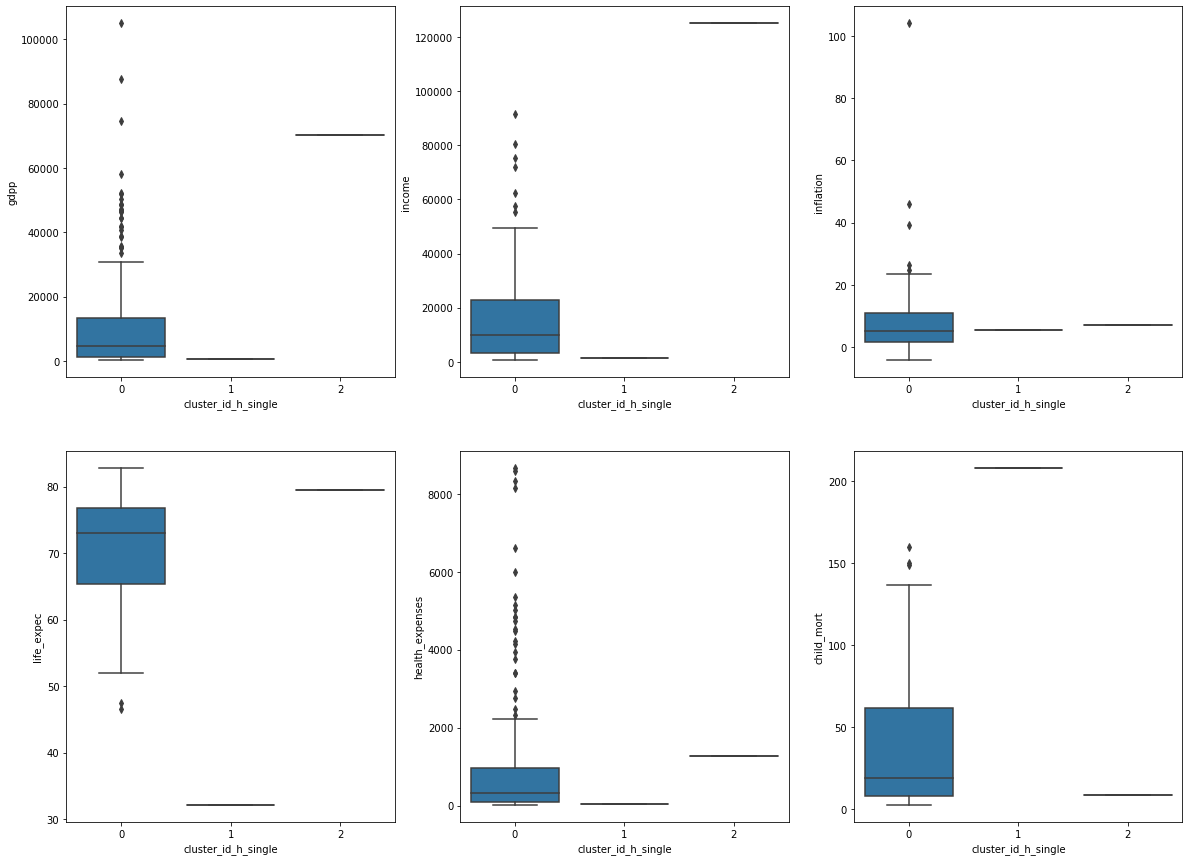

In [35]:
# plot
plt.figure(figsize=(20, 15))
plt.subplot(2,3,1)
sns.boxplot(x='cluster_id_h_single', y='gdpp', data=country_df)
plt.subplot(2,3,2)
sns.boxplot(x='cluster_id_h_single', y='income', data=country_df)
plt.subplot(2,3,3)
sns.boxplot(x='cluster_id_h_single', y='inflation', data=country_df)
plt.subplot(2,3,4)
sns.boxplot(x='cluster_id_h_single', y='life_expec', data=country_df)
plt.subplot(2,3,5)
sns.boxplot(x='cluster_id_h_single', y='health_expenses', data=country_df)
plt.subplot(2,3,6)
sns.boxplot(x='cluster_id_h_single', y='child_mort', data=country_df)
plt.show()

##### Here though there are 3 clusters formed, almost all the datapoints are concentrated within the cluster 0. The cluster 1 & 2 has only 1 datapoint each. Hence this is not right clustering that can be used. 
##### In the below , we will use the complete linkages for the hierarchical clustering and will build the dendrogram 

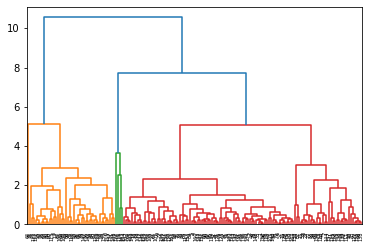

In [36]:
# complete linkage
mergings = linkage(grouped_df_scaled_h, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [37]:
# 3 clusters for having the right comparison with K-Means clustering output
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [38]:
# assign cluster labels
country_df['cluster_id_h_complete'] = cluster_labels

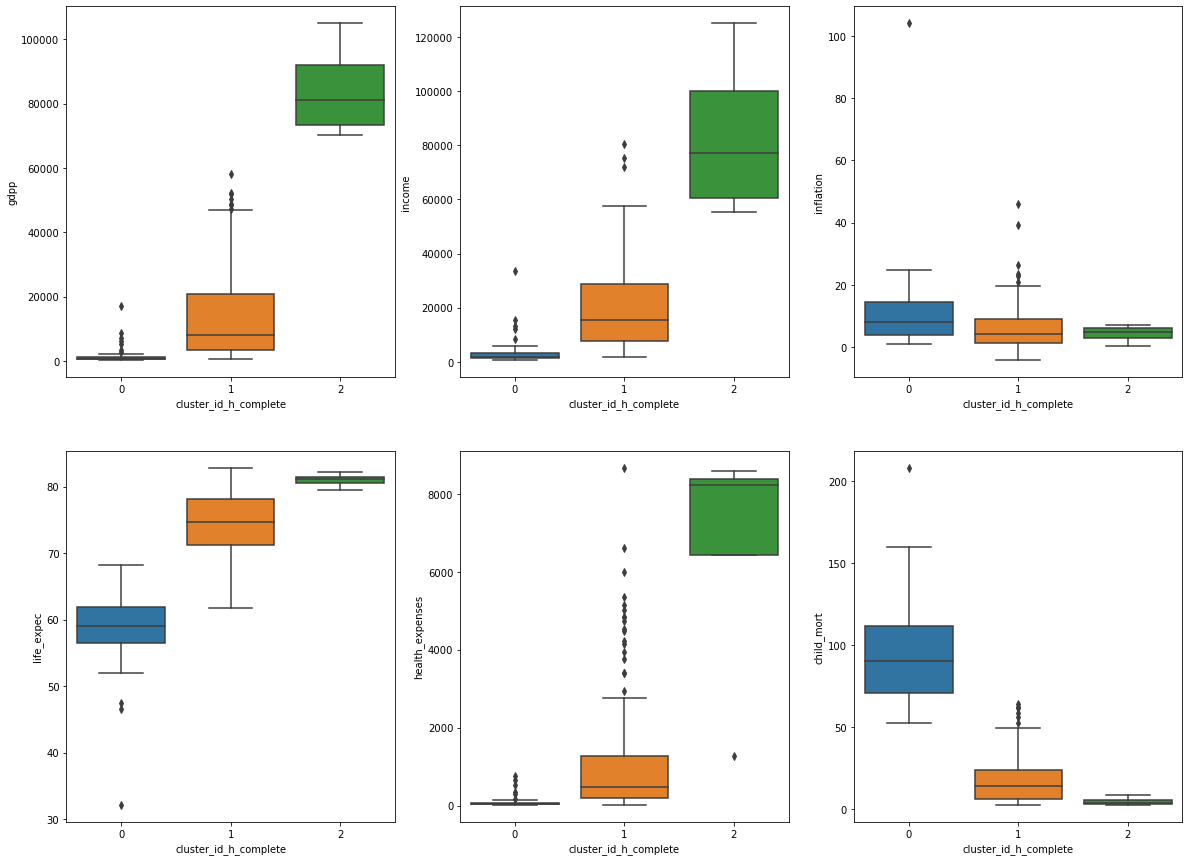

In [39]:
# plot
plt.figure(figsize=(20, 15))
plt.subplot(2,3,1)
sns.boxplot(x='cluster_id_h_complete', y='gdpp', data=country_df)
plt.subplot(2,3,2)
sns.boxplot(x='cluster_id_h_complete', y='income', data=country_df)
plt.subplot(2,3,3)
sns.boxplot(x='cluster_id_h_complete', y='inflation', data=country_df)
plt.subplot(2,3,4)
sns.boxplot(x='cluster_id_h_complete', y='life_expec', data=country_df)
plt.subplot(2,3,5)
sns.boxplot(x='cluster_id_h_complete', y='health_expenses', data=country_df)
plt.subplot(2,3,6)
sns.boxplot(x='cluster_id_h_complete', y='child_mort', data=country_df)
plt.show()

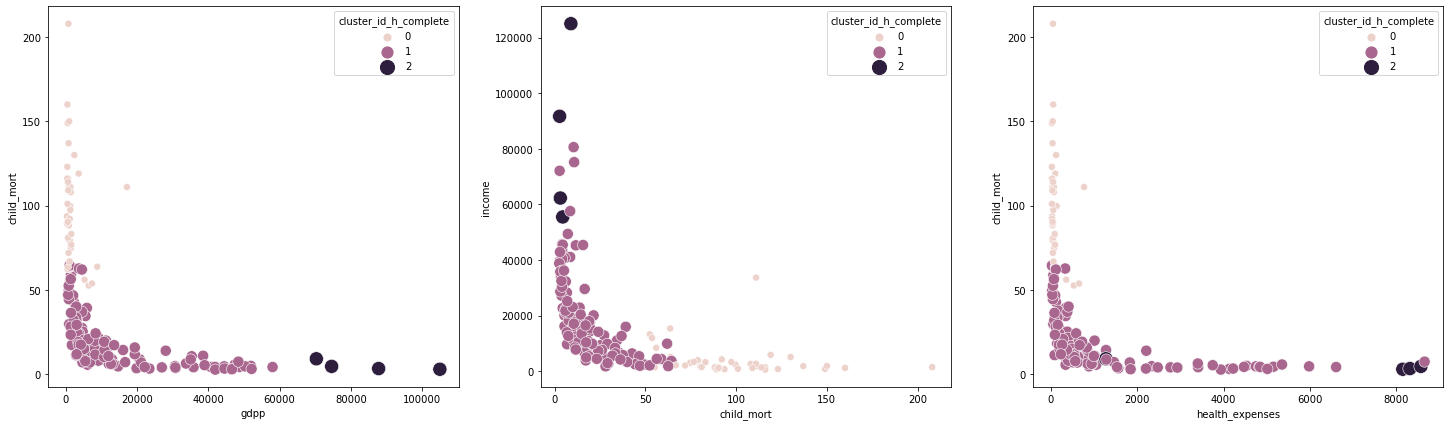

In [40]:
# plot
plt.figure(figsize=(25, 7))
plt.subplot(1,3,1)
sns.scatterplot(x='gdpp',y='child_mort',hue='cluster_id_h_complete', data=country_df,size='cluster_id_h_complete',sizes=(50,200))
plt.subplot(1,3,2)
sns.scatterplot(x='child_mort',y='income',hue='cluster_id_h_complete', data=country_df,size='cluster_id_h_complete',sizes=(50,200))
plt.subplot(1,3,3)
sns.scatterplot(x='health_expenses',y='child_mort',hue='cluster_id_h_complete', data=country_df,size='cluster_id_h_complete',sizes=(50,200))
plt.show()

#### Inference on Clusters that are built by the model
    * Cluster_id = 0 : 
            Very Low 
                GDPP
                Income
                Life Expectancy
                health expenses
            Very high
                Child Mortality rate

    * Cluster_id = 1 : 
           Medium 
                GDPP
                Income
                Life Expectancy
                health expenses
            Medium
                Child Mortality rate

    * Cluster_id = 2 : 
            Very High 
                GDPP
                Income
                Life Expectancy
                health expenses
            Very low
                Child Mortality rate


##### Based on the above cluster characteristics, it is clear that, the countries coming under cluster_id = 0 will be the ideal candidates for the NGO to provide the financial assistance 

### 5. Cluster profiling

##### a) Cluster profiling based on K-Means Clustering

<Figure size 1080x504 with 0 Axes>

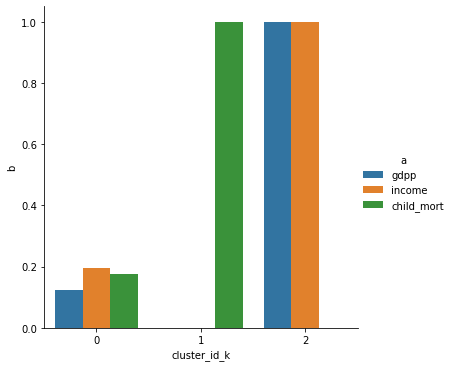

In [41]:
## Cluster profiling is done by grouping the data based on cluster and identifying the mean value of gdpp, income and child_mortality
## As the data of 3 attributes are in the different range, the scaling is done on the data to standardise the data and show it on the graph
cluster_profile_df = country_df.groupby('cluster_id_k')[['cluster_id_k','gdpp','income','child_mort']].mean()
#Scaling
min_max_scaler = preprocessing.MinMaxScaler()
cluster_profile_df_scaled = min_max_scaler.fit_transform(cluster_profile_df[['gdpp','income','child_mort']])
cluster_profile_df_scaled = pd.DataFrame(cluster_profile_df_scaled)
cluster_profile_df_scaled.columns = ['gdpp','income','child_mort']
#adding the cluster_id column to the scaled data
cluster_profile_df_scaled['cluster_id_k'] = cluster_profile_df.cluster_id_k
# transposing the data 
data_df = cluster_profile_df_scaled.melt('cluster_id_k', var_name='a', value_name='b')
# graph showing the comparison of the mean of the gdpp, income and child mortality
plt.figure(figsize=(15, 7))
sns.catplot(x='cluster_id_k', y='b', hue='a', data=data_df, kind='bar')
plt.show()

##### b) Cluster profiling based on Hierarchical (complete) Clustering

<Figure size 1080x504 with 0 Axes>

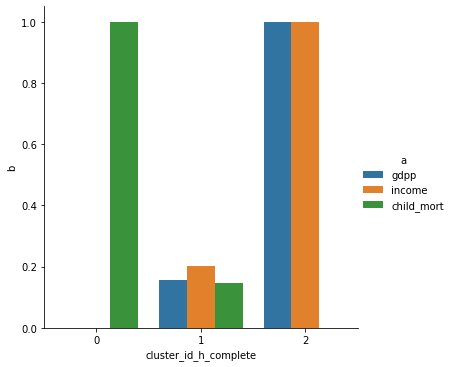

In [42]:
## Cluster profiling is done by grouping the data based on cluster and identifying the mean value of gdpp, income and child_mortality
## As the data of 3 attributes are in the different range, the scaling is done on the data to standardise the data and show it on the graph
cluster_profile_df = country_df.groupby('cluster_id_h_complete')[['cluster_id_h_complete','gdpp','income','child_mort']].mean()
#Scaling
min_max_scaler = preprocessing.MinMaxScaler()
cluster_profile_df_scaled = min_max_scaler.fit_transform(cluster_profile_df[['gdpp','income','child_mort']])
cluster_profile_df_scaled = pd.DataFrame(cluster_profile_df_scaled)
cluster_profile_df_scaled.columns = ['gdpp','income','child_mort']
#adding the cluster_id column to the scaled data
cluster_profile_df_scaled['cluster_id_h_complete'] = cluster_profile_df.cluster_id_h_complete
# transposing the data 
data_df = cluster_profile_df_scaled.melt('cluster_id_h_complete', var_name='a', value_name='b')
# graph showing the comparison of the mean of the gdpp, income and child mortality
plt.figure(figsize=(15, 7))
sns.catplot(x='cluster_id_h_complete', y='b', hue='a', data=data_df, kind='bar')
plt.show()

#### Inference 
    The cluster_id = 0 has very low income and GDPP value where as it has very high child mortality rate. 
    Hence we need to pick the countries in the cluster #1  
    Identify the top 5 countries in the cluster that has lowest GDPP & income and very high child mortality rate.

In [43]:
final_dataset = country_df[country_df.cluster_id_k == 1]
final_dataset.sort_values(['gdpp','income','child_mort'],ascending = [True,True,False])[['country','gdpp','income','child_mort']].head()

,country,gdpp,income,child_mort
26,Burundi,231,764,93.6
88,Liberia,327,700,89.3
37,"Congo, Dem. Rep.",334,609,116.0
112,Niger,348,814,123.0
132,Sierra Leone,399,1220,160.0


In [44]:
final_dataset = country_df[country_df.cluster_id_h_complete == 0]
final_dataset.sort_values(['gdpp','income','child_mort'],ascending = [True,True,False])[['country','gdpp','income','child_mort']].head()

,country,gdpp,income,child_mort
26,Burundi,231,764,93.6
88,Liberia,327,700,89.3
37,"Congo, Dem. Rep.",334,609,116.0
112,Niger,348,814,123.0
132,Sierra Leone,399,1220,160.0


# FINAL INFERENCE

#### Below are the 5 countries that the NGO can provide the financial assistance to help reducing the child mortality  
    Country          GDPP   Income  Child mortality
    Burundi          231	764      93.6
    Liberia          327	700      89.3
    Congo Dem Rep    334	609     116.0
    Niger            348	814     123.0
    Sierra Leone	 399	1220    160.0